## Augmentation, Morphology and Restoration

In [23]:
import numpy as np
from skimage.io import imread
from skimage.transform import rotate
from skimage.transform import warp, AffineTransform
import matplotlib.pyplot as plt 
%matplotlib inline

In [17]:
image = imread('image.jpg')
img_array = np.array(image)
print(img_array.shape)

(913, 688, 3)


In [20]:
# for rotation 
def rotate_image(cx, cy, theta):
    theta = np.deg2rad(theta)
    trans_mat = np.array([[1, 0, -cx],
                         [0, 1, -cy],
                         [0, 0, 1]])
    rot_mat = np.array([[np.cos(theta), -np.sin(theta), 0],
                        [np.sin(theta), np.cos(theta), 0],
                        [0, 0, 1]])
    trans_back = np.array([[1, 0, cx],
                         [0, 1, cy],
                         [0, 0, 1]])
    M = trans_back@rot_mat@trans_mat
                        
    return M

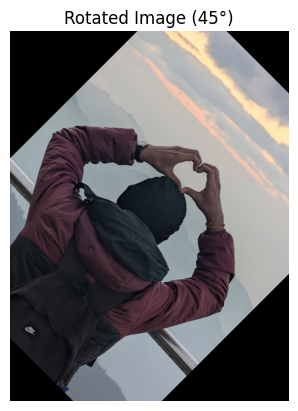

In [24]:
# Get center of image
cy, cx = image.shape[0] / 2, image.shape[1] / 2

# Get transformation matrix
M = rotate_image(cx, cy, theta=45)

# Wrap matrix into AffineTransform
tf = AffineTransform(matrix=M)

# Apply warp
rotated = warp(image, inverse_map=tf.inverse)

# Show result
plt.imshow(rotated)
plt.title("Rotated Image (45°)")
plt.axis('off')
plt.show()